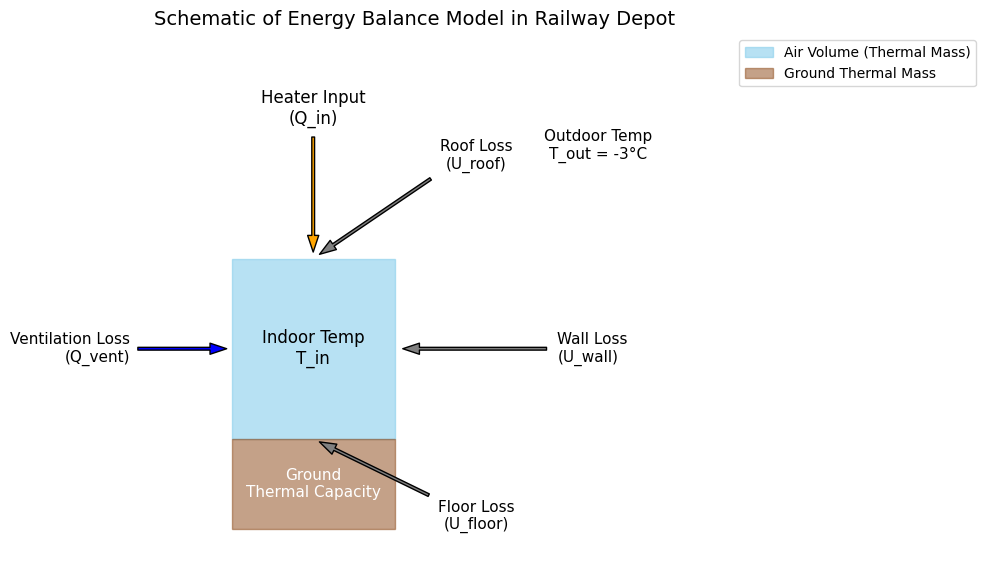

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Create schematic plot
fig, ax = plt.subplots(figsize=(10, 6))

# Air volume block
air_box = plt.Rectangle((0.3, 0.3), 0.4, 0.4, color='skyblue', label='Air Volume (Thermal Mass)', alpha=0.6)
ax.add_patch(air_box)

# Ground thermal capacity block
ground_block = plt.Rectangle((0.3, 0.1), 0.4, 0.2, color='saddlebrown', label='Ground Thermal Mass', alpha=0.5)
ax.add_patch(ground_block)
ax.text(0.5, 0.2, 'Ground\nThermal Capacity', ha='center', va='center', fontsize=11, color='white')

# Heat input (radiant panel)
ax.annotate('Heater Input\n(Q_in)', xy=(0.5, 0.7), xytext=(0.5, 1.0),
            arrowprops=dict(facecolor='orange', shrink=0.05, width=2, headwidth=8),
            ha='center', fontsize=12)

# Heat loss through walls
ax.annotate('Wall Loss\n(U_wall)', xy=(0.7, 0.5), xytext=(1.1, 0.5),
            arrowprops=dict(facecolor='gray', shrink=0.05, width=2, headwidth=8),
            va='center', fontsize=11)

# Heat loss through roof
ax.annotate('Roof Loss\n(U_roof)', xy=(0.5, 0.7), xytext=(0.9, 0.9),
            arrowprops=dict(facecolor='gray', shrink=0.05, width=2, headwidth=8),
            ha='center', fontsize=11)

# Heat loss through floor
ax.annotate('Floor Loss\n(U_floor)', xy=(0.5, 0.3), xytext=(0.9, 0.1),
            arrowprops=dict(facecolor='gray', shrink=0.05, width=2, headwidth=8),
            ha='center', fontsize=11)

# Ventilation loss arrow
ax.annotate('Ventilation Loss\n(Q_vent)', xy=(0.3, 0.5), xytext=(0.05, 0.5),
            arrowprops=dict(facecolor='blue', shrink=0.05, width=2, headwidth=8),
            va='center', ha='right', fontsize=11)

# Indoor temperature label
ax.text(0.5, 0.5, 'Indoor Temp\nT_in', ha='center', va='center', fontsize=12, color='black')

# Outdoor temperature label - Updated to match simulation
ax.text(1.2, 0.95, 'Outdoor Temp\nT_out = -3°C', ha='center', va='center', fontsize=11, color='black')

# Axis settings
ax.set_xlim(0, 1.5)
ax.set_ylim(0, 1.2)
ax.axis('off')

# Title and legend
plt.title('Schematic of Energy Balance Model in Railway Depot', fontsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10)
plt.tight_layout()
plt.show()



### Ground Thermal Capacity
Determine value for `ground_thermal_capacity`

To calculate it from first principles: 

$$C_{ground} = m_{ground} \cdot c_{p, soil}$$

Where:
* $C_{ground}$ is the thermal capacity of the ground in $J/K$.
* $m_{ground}$ is the mass of the soil (in kg) that is thermally coupled with the building. This is the hardest value to determine, as it requires knowing the effective depth of heat penetration into the ground over the simulation time.
* $c_{p, soil}$ is the specific heat capacity of the soil (you correctly note a typical value is around $1000 \, J/(kg \cdot K)$).

For context, if we assume an effective depth of just $0.5 \, m$ of soil beneath the depot floor ($3800 \, m^2$) with a typical soil density of $1500 \, kg/m^3$:

* **Volume:** $3800 \, m^2 \times 0.5 \, m = 1900 \, m^3$
* **Mass:** $1900 \, m^3 \times 1500 \, kg/m^3 = 2.85 \times 10^6 \, kg$
* **Calculated Thermal Capacity:** $2.85 \times 10^6 \, kg \times 1000 \, J/(kg \cdot K) = 2.85 \times 10^9 \, J/K$


### The Mathematical Model
The code numerically solves a **first-order ordinary differential equation (ODE)** that describes the energy balance of the depot. The fundamental principle is the first law of thermodynamics: the change in the internal energy of the system is equal to the net heat added to the system.

The core equation for the indoor temperature ($T_{in}$) over time ($t$) is:

$$\frac{dT_{in}}{dt} = \frac{Q_{net}}{C_{total}}$$

#### 1. Total Thermal Capacity ($C_{total}$)

This represents the system's resistance to temperature change. In the model, it's the sum of the thermal capacity of the air and the ground.

$$C_{total} = C_{air} + C_{ground}$$

* **Air Thermal Capacity ($C_{air}$):** Calculated as the product of the air's volume ($V_{air}$), density ($\rho_{air}$), and specific heat capacity ($c_{p,air}$).
    $$C_{air} = V_{air} \cdot \rho_{air} \cdot c_{p,air}$$
* **Ground Thermal Capacity ($C_{ground}$):** The assumed value discussed above.

#### 2. Net Heat Flow Rate ($Q_{net}$)

This is the rate at which energy is added to the system (in Watts, or Joules per second). It's the difference between the heat generated by the panels and the heat lost to the environment.

$$Q_{net} = Q_{panels} - Q_{loss}$$

* **Heating Power ($Q_{panels}$):** The heat supplied by the panels.
    $$Q_{panels} = N_{panels} \cdot P_{panel}$$
* **Total Heat Loss ($Q_{loss}$):** The sum of heat loss from conduction (through the building envelope) and ventilation (air exchange).
    $$Q_{loss} = Q_{conduction} + Q_{ventilation}$$

#### 3. Heat Loss Mechanisms

Heat loss is driven by the temperature difference between the inside and outside, $\Delta T = T_{in} - T_{out}$.

* **Conduction Loss ($Q_{conduction}$):** Heat transfer through the building's surfaces (walls, windows, etc.). It is calculated by summing the heat flow through each component, governed by its area ($A$) and U-value ($U$).
    $$Q_{conduction} = (\sum_{i} U_i A_i) \cdot \Delta T$$
    The code sums the contributions from solid walls, windows, shutters, the roof, and the floor.
    $$\sum U_i A_i = (U_{solid}A_{solid} + U_{win}A_{win} + U_{shut}A_{shut} + U_{roof}A_{roof} + U_{floor}A_{floor})$$

* **Ventilation Loss ($Q_{ventilation}$):** Heat lost by replacing warm indoor air with cold outdoor air.
    $$Q_{ventilation} = \dot{m}_{air} \cdot c_{p,air} \cdot \Delta T$$
    Where the mass flow rate of air ($\dot{m}_{air}$) is determined by the Air Changes per Hour (ACH) and the building volume ($V_{air}$).
    $$\dot{m}_{air} = \frac{ACH \cdot V_{air}}{3600} \cdot \rho_{air}$$

#### 4. Numerical Solution

The code does not solve the differential equation analytically. Instead, it uses the **Euler method**, a numerical technique to approximate the solution over discrete time steps ($\Delta t$). The temperature at the next time step ($T_{t+1}$) is found from the temperature at the current time step ($T_t$):

$$T_{t+1} = T_t + \Delta T_{in}$$

Where the change in temperature is calculated as:

$$\Delta T_{in} = \frac{Q_{net} \cdot \Delta t}{C_{total}}$$

This is exactly what your `for` loop implements:
`temps[t] = temps[t-1] + (net_heat * time_step) / total_thermal_capacity`

This is a valid and common approach for this type of thermal simulation.

Wall area total: 1973.4 m²
Solid wall area: 1235.9 m²
Window area: 715.0 m²
Shutter area: 22.5 m²


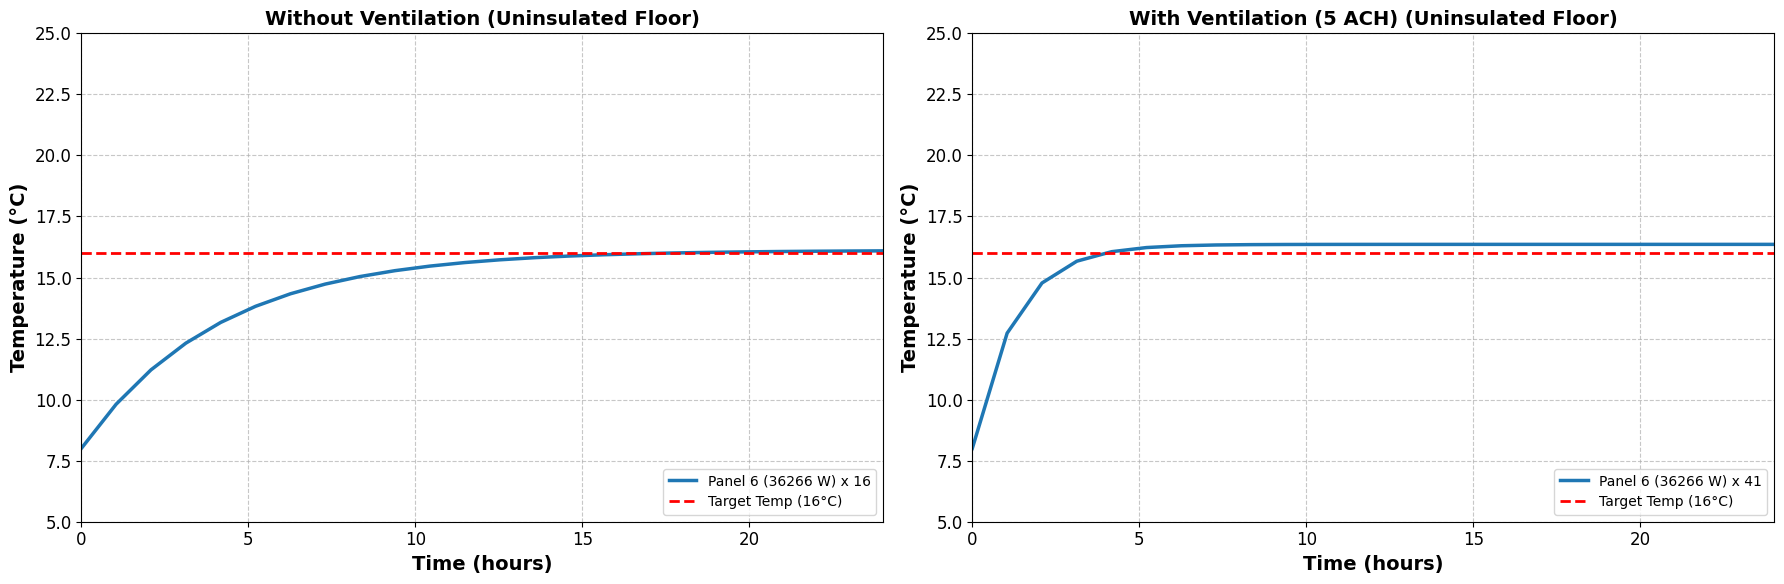


Heating Panel Summary:
Without Ventilation:
- Panel 6 (36266 W): Panels needed = 16

With Ventilation (5 ACH):
- Panel 6 (36266 W): Panels needed = 41

Validation:
Building volume: 27170 m³
Air thermal capacity: 33449666 J/K
Ground thermal capacity: 456000000 J/K
Total thermal capacity: 489449666 J/K
Ground/Air capacity ratio: 13.6


In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Depot dimensions

length = 100.0        # m
width = 38.0          # m
height = 0.5*(8.5+5.8)         # m

wall_area_total = 2 * height * (length + width)  # m²
# Wall breakdown
side_wall_area = height * length  # each long side
window_area = 0.5 * side_wall_area * 2  # 50% of both long sides
shutter_area = 22.5  # total 22.5 m²
solid_wall_area = wall_area_total - window_area - shutter_area

print("Wall area total:", wall_area_total, "m²")
print("Solid wall area:", solid_wall_area, "m²")
print("Window area:", window_area, "m²")
print("Shutter area:", shutter_area, "m²")

# Ground insulation condition
ground_insulation = False # True for insulated floor, False for uninsulated floor

# U-values
U_solid_wall = 1.6      # W/(m²·K) Cavity wall, no insulation
U_window = 5.0          # W/(m²·K) Single glazed
U_shutter = 4.5         # W/(m²·K)
U_roof = 5.0            # W/(m²·K) Perspex/Glass
if ground_insulation:
    U_floor = 0.2           # W/(m²·K)  # 0.2 W/(m²·K) for insulated floor
else:
    U_floor = 1.5           # W/(m²·K)  # 1.5 W/(m²·K) for uninsulated floor

roof_area = length * width                 # m²
floor_area = roof_area                     # m²

# Temperature setup
inside_temp_target = 16.0    # °C
initial_inside_temp = 8.0   # °C
outside_temp = -3.0          # °C

panel_single_energy = [36266]  # W
# panel references: 1,2,3,4,5,6,7,8
ref_panel_names = [
    "Panel 6 (36266 W)"
]

# Ground & air thermal properties
if ground_insulation:
    ground_thermal_capacity = 0
else:
    ground_thermal_capacity = floor_area * 120e3  # ~4.6×10^8 J/K

air_density = 1.225         # kg/m³
specific_heat_air = 1005    # J/(kg·K)

# Ventilation
enable_ventilation = True # not decided yet !
air_change_rate_per_hour = 5 # ACH (5-8 or 8-12 ACH found in the literature)

# Simulation time
time_step = 3600 # seconds
total_simulation_time = 24 * 3600  # 24 hours
time_steps = int(total_simulation_time / time_step)
time = np.linspace(0, total_simulation_time, time_steps) / 3600  # in hours

# DERIVED PARAMETERS

volume_air = height * width * length  # m³
thermal_capacity_air = volume_air * air_density * specific_heat_air  # J/K
total_thermal_capacity = thermal_capacity_air + ground_thermal_capacity
if total_thermal_capacity <= 0:
    raise ValueError("Total thermal capacity is zero or negative.")


# FUNCTIONS
def calculate_heat_loss(delta_T):
    wall_loss = (
        solid_wall_area * U_solid_wall +
        window_area * U_window +
        shutter_area * U_shutter
    ) * delta_T
    roof_loss = roof_area * U_roof * delta_T
    floor_loss = floor_area * U_floor * delta_T
    return wall_loss + roof_loss + floor_loss

def calculate_ventilation_loss(delta_T):
    if not enable_ventilation:
        return 0.0
    air_flow_rate = (air_change_rate_per_hour * volume_air) / 3600  # m³/s
    return air_density * specific_heat_air * air_flow_rate * delta_T  # W

def simulate_heating(panel_power):
    temps = np.zeros(time_steps)
    temps[0] = initial_inside_temp

    for t in range(1, time_steps):
        delta_T = temps[t-1] - outside_temp
        heat_loss = calculate_heat_loss(delta_T) + calculate_ventilation_loss(delta_T)
        net_heat = panel_power - heat_loss
        temps[t] = temps[t-1] + (net_heat * time_step) / total_thermal_capacity
    return temps

# MAIN CALCULATION LOOP
panel_results = []
for panel_idx, panel_power in enumerate(panel_single_energy):
    min_panels = 8
    max_panels = 20
    found = False
    for num_panels in range(min_panels, max_panels + 1):
        total_power = panel_power * num_panels
        temperature_profile = simulate_heating(total_power)
        final_temp = temperature_profile[-1]
        if final_temp >= inside_temp_target:
            panel_results.append({
                'panel_type': ref_panel_names[panel_idx],  # Use correct panel name
                'num_panels': num_panels,
                'temperature_profile': temperature_profile
            })
            found = True
            break  # CRITICAL: This break was commented out - it should be active
    if not found:
        panel_results.append({
            'panel_type': ref_panel_names[panel_idx],  # Use correct panel name
            'num_panels': 'Not sufficient (max limit reached)',
            'temperature_profile': None
        })

# RESULTS AND PLOTS

# Set better font parameters for presentations
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 10
})

# Create 1x2 subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Function to run simulation with different ventilation settings
def run_simulation_with_ventilation(ventilation_enabled):
    temp_enable_ventilation = ventilation_enabled
    
    def calculate_ventilation_loss_temp(delta_T):
        if not temp_enable_ventilation:
            return 0.0
        air_flow_rate = (air_change_rate_per_hour * volume_air) / 3600  # m³/s
        return air_density * specific_heat_air * air_flow_rate * delta_T  # W
    
    def simulate_heating_temp(panel_power):
        temps = np.zeros(time_steps)
        temps[0] = initial_inside_temp

        for t in range(1, time_steps):
            delta_T = temps[t-1] - outside_temp
            heat_loss = calculate_heat_loss(delta_T) + calculate_ventilation_loss_temp(delta_T)
            net_heat = panel_power - heat_loss
            temps[t] = temps[t-1] + (net_heat * time_step) / total_thermal_capacity
        return temps
    
    # Run simulation for each panel configuration
    temp_results = []
    for panel_idx, panel_power in enumerate(panel_single_energy):
        min_panels = 8
        max_panels = 50
        found = False
        for num_panels in range(min_panels, max_panels + 1):
            total_power = panel_power * num_panels
            temperature_profile = simulate_heating_temp(total_power)
            final_temp = temperature_profile[-1]
            if final_temp >= inside_temp_target:
                temp_results.append({
                    'panel_type': ref_panel_names[panel_idx],
                    'num_panels': num_panels,
                    'temperature_profile': temperature_profile
                })
                found = True
                break
        if not found:
            temp_results.append({
                'panel_type': ref_panel_names[panel_idx],
                'num_panels': 'Not sufficient (max limit reached)',
                'temperature_profile': None
            })
    
    return temp_results

# Plot 1: No Ventilation
results_no_vent = run_simulation_with_ventilation(False)
for result in results_no_vent:
    if result['temperature_profile'] is not None:
        ax1.plot(time, result['temperature_profile'], label=f"{result['panel_type']} x {result['num_panels']}", linewidth=2.5)
    else:
        print(f"No Ventilation - {result['panel_type']}: Insufficient heating even with {max_panels} panels.")

ax1.axhline(inside_temp_target, color='red', linestyle='--', label='Target Temp (16°C)', linewidth=2)
ax1.set_xlabel('Time (hours)', fontweight='bold')
ax1.set_ylabel('Temperature (°C)', fontweight='bold')

title1 = "Without Ventilation"
if ground_insulation:
    title1 += " (Insulated Floor)"
else:
    title1 += " (Uninsulated Floor)"
ax1.set_title(title1, fontweight='bold')
ax1.set_ylim(5, 25)
ax1.set_xlim(0, total_simulation_time / 3600)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(loc='lower right', fontsize=10)

# Plot 2: With Ventilation
results_with_vent = run_simulation_with_ventilation(True)
for result in results_with_vent:
    if result['temperature_profile'] is not None:
        ax2.plot(time, result['temperature_profile'], label=f"{result['panel_type']} x {result['num_panels']}", linewidth=2.5)
    else:
        print(f"With Ventilation - {result['panel_type']}: Insufficient heating even with {max_panels} panels.")

ax2.axhline(inside_temp_target, color='red', linestyle='--', label='Target Temp (16°C)', linewidth=2)
ax2.set_xlabel('Time (hours)', fontweight='bold')
ax2.set_ylabel('Temperature (°C)', fontweight='bold')

title2 = "With Ventilation (5 ACH)"
if ground_insulation:
    title2 += " (Insulated Floor)"
else:
    title2 += " (Uninsulated Floor)"
ax2.set_title(title2, fontweight='bold')
ax2.set_ylim(5, 25)
ax2.set_xlim(0, total_simulation_time / 3600)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()

# ========================
# TEXTUAL SUMMARY
# ========================

print("\nHeating Panel Summary:")
print("Without Ventilation:")
for result in results_no_vent:
    print(f"- {result['panel_type']}: Panels needed = {result['num_panels']}")

print("\nWith Ventilation (5 ACH):")
for result in results_with_vent:
    print(f"- {result['panel_type']}: Panels needed = {result['num_panels']}")

# Additional validation information
print(f"\nValidation:")
print(f"Building volume: {volume_air:.0f} m³")
print(f"Air thermal capacity: {thermal_capacity_air:.0f} J/K")
print(f"Ground thermal capacity: {ground_thermal_capacity:.0f} J/K")
print(f"Total thermal capacity: {total_thermal_capacity:.0f} J/K")
print(f"Ground/Air capacity ratio: {ground_thermal_capacity/thermal_capacity_air:.1f}")


## Refrence

### Gound termal capacity
1. https://www.designingbuildings.co.uk/wiki/Kappa%20value%20-%20thermal%20mass%20value?utm_source
Published values from standards and guidelines
Kappa (thermal mass) values (SAP/SBEM)
Dense concrete floor/ceiling: 120–160 kJ/m²·K 
This metric represents heat capacity per square metre per Kelvin

### ACH for warehouse / industrial space
1. https://www.atlenv.com/building-ventilation-the-proper-air-changes-per-hour-ach?utm_source
6-30 ACH
2. https://energy-models.com/forum/warehouse-ventilations-comply-ashrae-621?utm_source
5-8 ACH

